In [1]:
from cleanData import clean_text

from pathlib import Path
import pandas as pd
import numpy as np
import string
import sys
import os
import pickle

In [2]:
data = pd.read_csv("Amazon_Unlocked_Mobile.csv")

In [3]:
values_init = data.shape[0]
data = data.dropna() #removing rows with any collumn having NA/null data
values_end = data.shape[0]
difference = values_init - values_end;
print("Quantidade inicial {} >>Após remover linhas com dados vazios>> Final {}".format(values_init,values_end))
print("Quantidade de amostras com dados faltantes >> {}".format(difference))
data.index = np.arange(data.shape[0])
data.head()

Quantidade inicial 413840 >>Após remover linhas com dados vazios>> Final 334335
Quantidade de amostras com dados faltantes >> 79505


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


# Cleaning Datas
*   clean the reviews Text >> REMOVE NUMBERS , ASCII ETC
*   OBS: i created this cleaner, you can see in cleanData.py, i used this algorithm before to train my own translator english to portuguese , i used transformer RNC and NLTK too.   

In [4]:
text_cleaned = lambda x: clean_text(x)
data['Reviews'] = data['Reviews'].apply(text_cleaned)
data['Brand Name'] = data['Brand Name'].apply(text_cleaned) 


# Looking for outliers
* there are some prices from samsung products in outliers

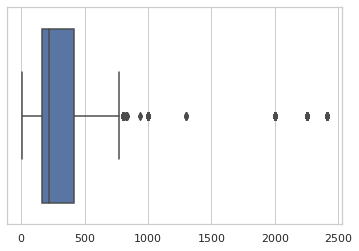

In [5]:
import seaborn as sns

dados = data.groupby(by="Brand Name")["Price"].apply(list)

sns.set(style="whitegrid")
ax = sns.boxplot(x=dados['samsung'])

# Selecting Data and adding some statistic.
* Generating Frequency | Mean Rate | Median Rate | Mode Rate | Sum of number votes reviews per brand.

In [6]:
dt_file = Path("./dt.pickle")
if dt_file.exists():
    print("dt.pickle exist")
else:
    print("generating pickle..")
    
    dados = data.groupby(by="Brand Name")['Rating'].apply(list)

    #   Mean Rate

    mean_rate_per_brand = lambda x: float("{:.3f}".format(np.mean(x)))

    filter_rate_mean = dados.map(mean_rate_per_brand)
    dt = pd.DataFrame(data= filter_rate_mean.index,columns=['Brand Name'])
    dt['Mean Rate'] = np.array(filter_rate_mean)
    
    
    #   Median Rate

    median_rate_per_brand = lambda x: float("{:.3f}".format(np.median(x)))
    filter_rate_median = dados.map(median_rate_per_brand)
    dt['Median Rate'] = np.array(filter_rate_median)

    # Mode
    moda = lambda x: list(pd.Series(x).mode())
    filter_moda = dados.map(moda)
    dt['Mode Rate'] = np.array(filter_moda)
    
    #   Generating Frequency
    
    result=[]
    for i in dt["Brand Name"]:
        result.append(data.loc[data["Brand Name"] == i].count()[0])

    dt['Frequency'] = result
    
    #   Sum of number votes reviews per brand
    
    sum_review_votes = lambda x: int("{}".format(np.sum(x)))

    filter_review_votes = np.array(dados.map(sum_review_votes))
    dt['Sum Votes'] = filter_review_votes
    
    # ordering per frequency
    
    dt = dt.sort_values(['Frequency'],ascending=False)
    dt.index = np.arange(dt.shape[0])
    
    # generate pickle
    
    dt.to_pickle('dt.pickle')

dt.pickle exist


## Considering just 20 best Brands for nexts Analysis

In [7]:
dt = pd.read_pickle(r'./dt.pickle')
dt = dt[0:20]
dt

,Brand Name,Mean Rate,Median Rate,Mode Rate,Frequency,Sum Votes
0,samsung,3.978,5.0,[5],65917,262235
1,blu,3.821,5.0,[5],59176,226118
2,apple,3.927,5.0,[5],56102,220290
3,lg,3.848,5.0,[5],21642,83277
4,blackberry,3.744,5.0,[5],17525,65618
5,nokia,3.825,5.0,[5],16199,61956
6,motorola,3.813,5.0,[5],13033,49693
7,htc,3.473,4.0,[5],12539,43548
8,cnpgd,3.108,3.0,[5],12302,38233
9,otterbox,4.385,5.0,[5],7880,34556


# Analysis Sentiment for Reviews
*   Polarity : is a float score within the range -1 (bad trend) to 1 (good trend) .
*   Subjectivity : 0 means very objective <> 1 means very subjective.

In [8]:
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity
#correction = lambda x: TextBlob(x).correct()

In [9]:

data_file = Path("./data.pickle")
if data_file.exists():
    data = pd.read_pickle(r'./data.pickle')
else:
    data['Polarity'] = data['Reviews'].apply(pol)
    data['Subjectivity'] = data['Reviews'].apply(sub)
    data.to_pickle('./data.pickle')

In [10]:
data.head(2)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Polarity,Subjectivity
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,5,feel so lucky to have found this used phone t...,1.0,0.164238,0.611000
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,4,nice phone nice up grade from my pantach revue...,0.0,0.449259,0.762222


* Add median and mean for Subjetivity and Polarity

In [11]:
dados = data.groupby(by="Brand Name")["Subjectivity"].apply(list)

# * Subjectivity
mean_subjectivity = lambda x : float("{:.3f}".format(np.mean(x)))
sub_mean_data = dados.map(mean_subjectivity)
#
median_subjectivity = lambda x : float("{:.3f}".format(np.median(x)))
sub_median_data = dados.map(median_subjectivity)

# * Polarity
dados = data.groupby(by="Brand Name")["Polarity"].apply(list)
mean_polarity = lambda x: float("{:.3f}".format(np.mean(x)))
pol_mean_data = dados.map(mean_polarity)
#
median_polarity = lambda x: float("{:.3f}".format(np.median(x)))
pol_median_data = dados.map(median_polarity)

polarity_mean       = []
subjectivity_mean   = []
polarity_median     = []
subjectivity_median = []

top20_brands = dt["Brand Name"]

for brand in top20_brands:
    polarity_mean.append(pol_mean_data[brand])
    subjectivity_mean.append(sub_mean_data[brand])
    
    polarity_median.append(pol_median_data[brand])
    subjectivity_median.append(sub_median_data[brand])

dt['Mean Polarity'      ]= polarity_mean
dt['Median Polarity'    ]= polarity_median
dt['Mean Subjectivity'  ]= subjectivity_mean
dt['Median Subjectivity']= subjectivity_median



In [12]:
dt

,Brand Name,Mean Rate,Median Rate,Mode Rate,Frequency,Sum Votes,Mean Polarity,Median Polarity,Mean Subjectivity,Median Subjectivity
0,samsung,3.978,5.0,[5],65917,262235,0.333,0.300,0.538,0.583
1,blu,3.821,5.0,[5],59176,226118,0.304,0.260,0.526,0.567
2,apple,3.927,5.0,[5],56102,220290,0.338,0.329,0.548,0.600
3,lg,3.848,5.0,[5],21642,83277,0.312,0.275,0.536,0.567
4,blackberry,3.744,5.0,[5],17525,65618,0.239,0.144,0.436,0.500
5,nokia,3.825,5.0,[5],16199,61956,0.274,0.237,0.518,0.550
6,motorola,3.813,5.0,[5],13033,49693,0.293,0.257,0.531,0.552
7,htc,3.473,4.0,[5],12539,43548,0.266,0.230,0.523,0.552
8,cnpgd,3.108,3.0,[5],12302,38233,0.198,0.142,0.465,0.509
9,otterbox,4.385,5.0,[5],7880,34556,0.368,0.350,0.560,0.600


# 1) Análise
*   Podemos ver a relação entre 'Mean Subjectivity' e 'Mean Rate'
*   Percebe-se que há uma área de interesse quando a média de subjetividade é maior que 0.51, assim também como a média de avaliação (rate) é maior que 3.4
*   Propõe-se, a partir dessa análise, que os produtos melhores classificados tendem a ter uma descrição (review) mais detalhada.

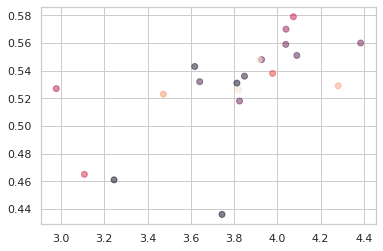

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

N = 20

x=np.array(dt['Mean Rate'])
y=np.array(dt['Mean Subjectivity'])
colors = np.random.rand(N)

plt.scatter(x, y, c=colors, alpha=0.5)
plt.show()

# 2) Análise
*   As marcas que são mais vendidas possuem um número maior de interação com as reviews dos clientes que já adiquiriram, o produto, porém , mesmo as marcas que possuem uma frequencia baixa de reviews, possuem um certo nivel consideravel de interação com as reviews.

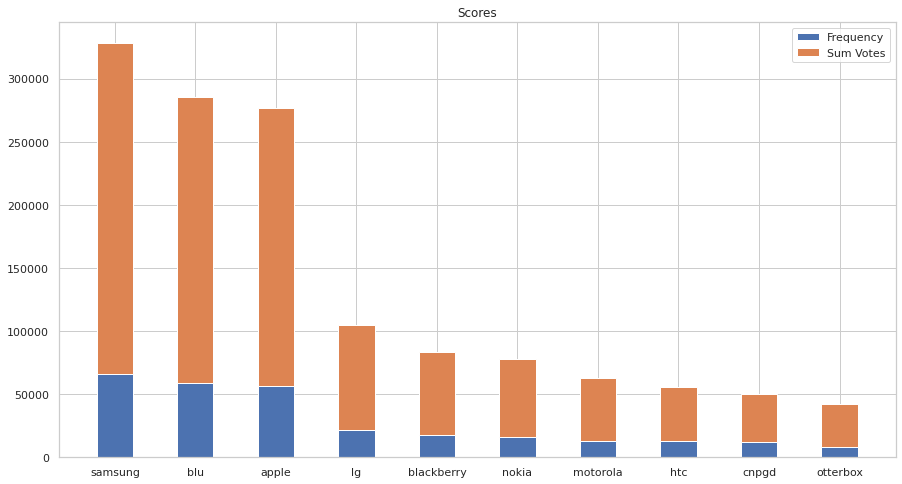

In [14]:
labels = dt['Brand Name'][0:10]
women_means = dt['Sum Votes'][0:10]
men_means = dt['Frequency'][0:10]
width = 0.45     

fig, ax = plt.subplots(figsize=(15,8))

ax.bar(labels, men_means, width, label='Frequency')
ax.bar(labels, women_means, width, bottom=men_means,label='Sum Votes')

ax.set_title('Scores')
ax.legend()

plt.show()

# 3) Análise
* Obs: O índice de polaridade significa ser o quão favorável foi o review do cliente, -1 = muito ruim, 1 = muito bom
* Analisando o gráfico de barras abaixo podemos ver a relação do indice de polaridade com o rate (quantidade de estrelas) em média que foi concedido pelos clientes.Portanto há uma certa tendência de quando maior a avaliação (rate), melhor será positivamente o review do cliente.

In [15]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

dt = dt.sort_values(['Mean Polarity'],ascending=False)
dt.index = np.arange(dt.shape[0])

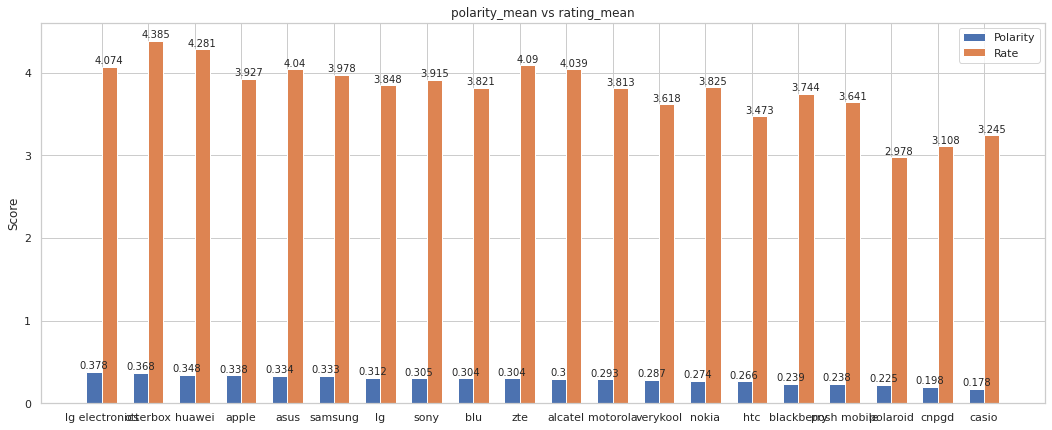

In [16]:
x = np.arange(len(dt['Brand Name']))  # the label locations
width = 0.33# the width of the bars
fig, ax = plt.subplots(figsize=(18,7))
rects1 = ax.bar(x - width/2, dt['Mean Polarity'], width, label='Polarity')
rects2 = ax.bar(x + width/2, dt['Mean Rate'], width, label='Rate')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('polarity_mean vs rating_mean')
ax.set_xticks(x)
ax.set_xticklabels(dt['Brand Name'])
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *
    rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() /2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()